In [1]:
import os
import sys

import findspark
findspark.init()

In [2]:
import pandas as pd
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array

In [3]:
ac_data = pd.read_csv("C:/Data-Attraper le flamand rose/ad-clicks.csv")

In [4]:
ac_data.head()

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing


In [5]:
##ajout d'un compteur 
ac_data['adCompteur'] = 1

In [6]:
ac_data.head()

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory,adCompteur
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics,1
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies,1
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers,1
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion,1
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing,1


In [7]:
gc_data = pd.read_csv("C:/Data-Attraper le flamand rose/game-clicks.csv")

In [8]:
gc_data['gcCompteur'] = 1
gc_data.head()

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel,gcCompteur
0,2016-05-26 15:06:55,105,1038,5916,0,25,1,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1,1


In [9]:
bc_data = pd.read_csv("C:/Data-Attraper le flamand rose/buy-clicks.csv")
bc_data.head()

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


In [10]:
u_purchases = bc_data[['userId','price']] #on selectionne uniquement l'userid et le prix
u_purchases.head()

,userId,price
0,1300,3.0
1,868,10.0
2,819,20.0
3,121,3.0
4,2222,20.0


In [11]:
u_purchases = bc_data[['userId','price']] #on selectionne uniquement l'userid et le prix
u_purchases.head()

,userId,price
0,1300,3.0
1,868,10.0
2,819,20.0
3,121,3.0
4,2222,20.0


In [12]:
u_aclicks = ac_data[['userId','adCompteur']]
u_aclicks.head()

,userId,adCompteur
0,611,1
1,1874,1
2,2139,1
3,212,1
4,1027,1


In [13]:
u_gameClicks = gc_data[['userId','gcCompteur']]
u_gameClicks.head()

,userId,gcCompteur
0,1038,1
1,1099,1
2,899,1
3,2197,1
4,1362,1


In [14]:
user_ads = u_aclicks.groupby('userId').sum()
user_ads = user_ads.reset_index()
user_ads.columns = ['userId', 'acdataTotal']
user_ads.head()

,userId,acdataTotal
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


In [15]:
user_gc_data = u_gameClicks.groupby('userId').sum()
user_gc_data = user_gc_data.reset_index()
user_gc_data.columns = ['userId', 'gcdataTotal']
user_gc_data.head()

,userId,gcdataTotal
0,0,1355
1,1,716
2,2,231
3,6,151
4,8,380


In [16]:
user_benefice = u_purchases.groupby('userId').sum()
user_benefice = user_benefice.reset_index()
user_benefice.columns = ['userId', 'benefice']
user_benefice.head()

,userId,benefice
0,1,21.0
1,8,53.0
2,9,80.0
3,10,11.0
4,12,215.0


In [17]:
data_combinaison = user_ads.merge(user_gc_data, on='userId') 
data_combinaison = data_combinaison.merge(user_benefice, on='userId') 
data_combinaison.head()

,userId,acdataTotal,gcdataTotal,benefice
0,1,44,716,21.0
1,8,10,380,53.0
2,9,37,508,80.0
3,10,19,3107,11.0
4,12,46,704,215.0


In [18]:
data_clustering = data_combinaison[['acdataTotal', 'gcdataTotal','benefice']]
data_clustering.head()

,acdataTotal,gcdataTotal,benefice
0,44,716,21.0
1,10,380,53.0
2,37,508,80.0
3,19,3107,11.0
4,46,704,215.0


In [19]:
#taille
data_clustering.shape

(543, 3)

In [20]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("sample_app")
sc = SparkContext(conf=conf)

In [22]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [23]:
sqlContext = SQLContext(sc)
training_df= sqlContext.createDataFrame(data_clustering)
training_data = training_df.rdd.map(lambda line: array([line[0], line[1], line[2]]))

In [24]:
model = KMeans.train(training_data , 3, maxIterations=10, runs=10, initializationMode="random")

C:\spark\python\pyspark\mllib\clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [25]:
#centre clusters
print(model.centers)

[array([ 24.98746082, 357.95924765,  35.06583072]), array([ 36.44134078, 926.11731844,  46.96648045]), array([  32.35555556, 2310.64444444,   39.42222222])]


In [27]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
print('Spark',pyspark.__version__)
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Spark 2.4.5


In [29]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
p_df = sqlContext.createDataFrame(data_clustering)
parsed_data = p_df.rdd.map(lambda line: array([line[0], line[1], line[2]])) #totalAdClicks, totalGameClicks, revenue

In [30]:
kMean_model = KMeans.train(parsed_data, 3, maxIterations=10, initializationMode="random")

In [32]:
data_headers = data_clustering.columns.values.tolist()
data_centers = [a.tolist() for a in kMean_model.centers]

In [35]:
total_df = pd.DataFrame(data_centers, columns=data_headers)
total_df.head()

,acdataTotal,gcdataTotal,benefice
0,24.466887,343.533113,34.519868
1,32.355556,2310.644444,39.422222
2,36.250000,899.066327,46.775510


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000205A971FF08>,
      dtype=object)

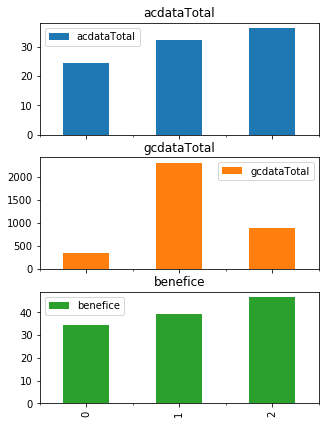

In [36]:
%matplotlib inline
total_df.plot(kind='bar',subplots=True, figsize=(5,7), use_index=True)